## Seminar 11.2. Reinforcement Learning. A2C




In [ ]:
!pip install gymnasium

In [ ]:
import sys, os

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

from dataclasses import dataclass
import typing as tt
from typing import List

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import gymnasium as gym

from IPython.display import clear_output

%matplotlib inline

Today, we conclude our overview of model-free RL methods.

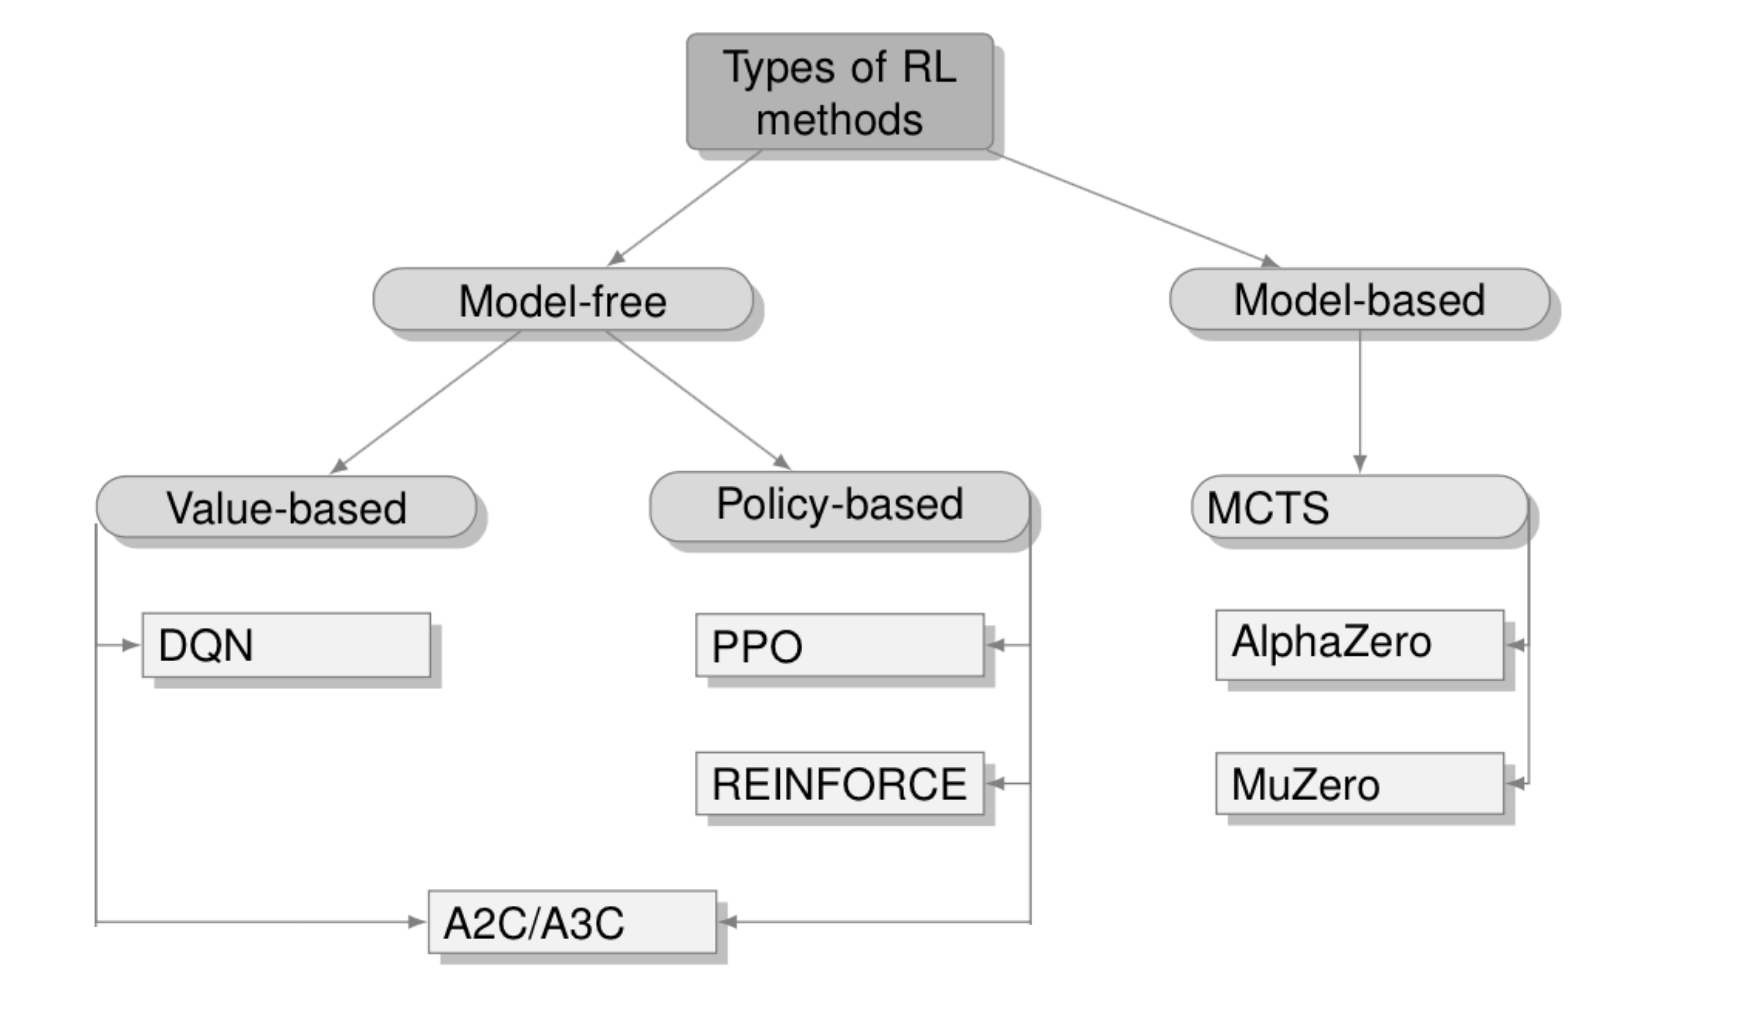

# 1. Actor-critic model (A2C)

The REINFORCE method updates the policy using the gradient  $$\nabla J = \mathbb{E}_{\pi_{\theta}} \left[Q_{\pi} (s, a) \nabla \log \pi \left( a \bigr| s \right)\right],$$ where $Q_{\pi}(s, a) = \mathbb{E}_{\pi}[G_t \vert S_t = s, A_t = a]$ is the action-value function under policy $\pi$.



*  A commonly used REINFORCE improvement involves subtracting a **baseline** from the return $$G_t = R_{t+1} + \gamma R_{t+2} + \dots = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}$$  to *reduce gradient variance without introducing bias*.

* A common baseline is state-value $V(s)$. The difference $$A(s, a) = Q(s, a) - V(s)$$ is called the **advantage**.

For the explaination why a baseline works see e.g. https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/

The idea of using a neural network to predict the state-value $V(s)$ leads to the **Actor-Critic** (**A2C**) model, where we have $2$ networks:

1.  The **actor** network, which outputs the probabilities of different actions, essentially telling the agent what to do.

2.  The **critic** network, which allows us to understand how good our actions were by returning  $V(s)$.

In practice, for efficiency, the actor and critic networks often share their initial processing layers.


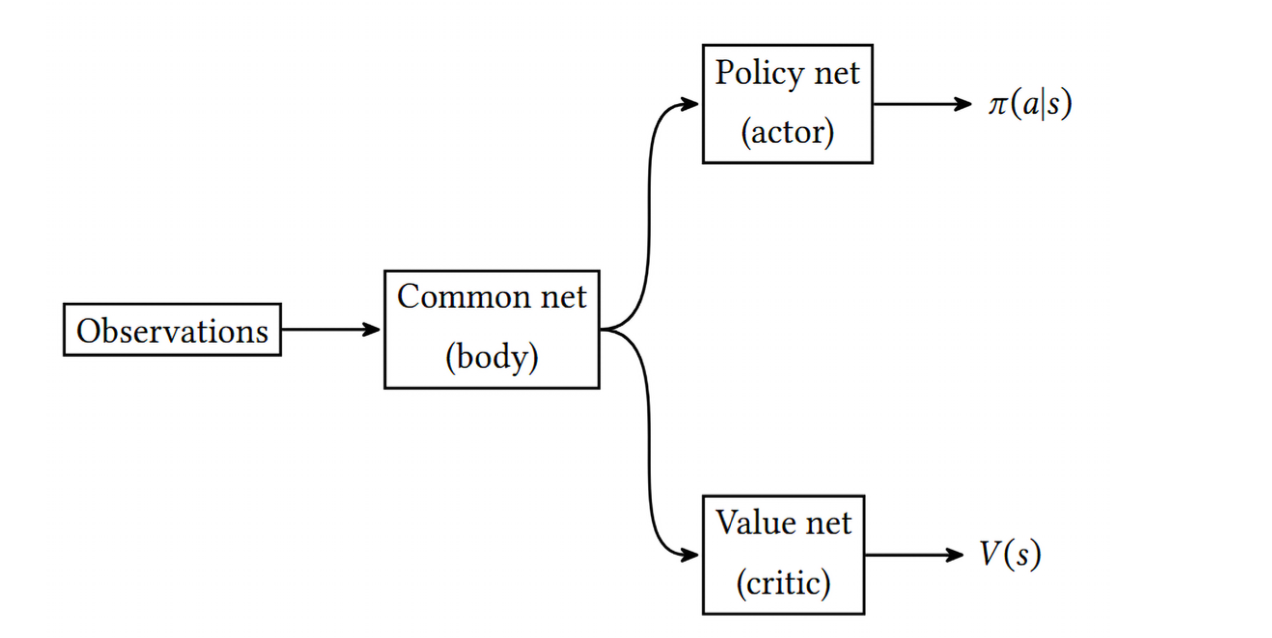

## 1.1 A2C algorithm

Let's take a brief look at the A2C algorithm.

1. Play $N$ steps in the environment and save the transitions (in an experience replay for example).

2. For every transition $(s, a, r, s')$ calculate the “advantage” depending on our critic and set $Q(s, a)=0$ if $s'$ is an end-state: $$\Delta = Q(s, a) - V(s).$$

3. Calculate the loss of actor and critic for every transition: $$L_w = - \Delta  \cdot \ln \pi_{\theta} (a_t | s_t), \qquad L_v = \Delta ^2.$$

4. Sum up the actor’s losses and the critic’s losses respectively.

5. Do the optimizer step for the actor and for the critic.

6. Repeat until converged.


This algorithm is just an outline. In practice, several modifications are often added to make it more stable.

* In Step 2, we can estimate $Q(s,a) = r + \gamma V(s')$. Alternatively, we could consider multi-step returns from the environment.

* In Step 4 **an entropy bonus** is usually added to the loss functions to improve exploration: $$\mathcal{L}_H = \beta \sum_i \pi_{\theta}(a_i) \log \pi_{\theta}(a_i).$$ This function has a minimum when the probability distribution is uniform, so by adding it to the loss function, we push our agent away from being too certain about its actions.


## 1.2 CartPole with A2C

An output where all values are equal is high entropy and an output with one value much higher than the others is low entropy. We try to keep a little bit of entropy around so that the agent explores more.

Constants

In [ ]:
MAX_FRAMES = 5000000
BATCH_SIZE = 5 # No of timesteps a worker runs for before the next worker
LEARNING_RATE = 1e-3
GAMMA = 0.99 # discount future rewards per timestep
ENTROPY_COEF = 0.01 # how much we maximise the entropy of the agent’s output
CRITIC_COEF = 0.5
NO_OF_WORKERS = 16 # how many environments to run simultaneously

Set seeds for reproducibility

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

Device and tensor types

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda available")
    FloatTensor = torch.cuda.FloatTensor
    LongTensor = torch.cuda.LongTensor
else:
    print("cuda not available")
    FloatTensor = torch.FloatTensor
    LongTensor = torch.LongTensor

cuda not available


For simplicty we consider simple [CartPole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

* The agent must learn to balance a pole on a cart with discrete left/right actions
* **Reward** of $+1$ is given for every step taken, including the termination step. The default reward threshold is $500$ for v1.


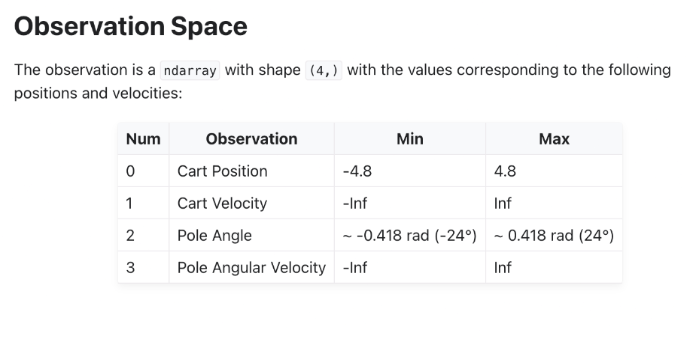

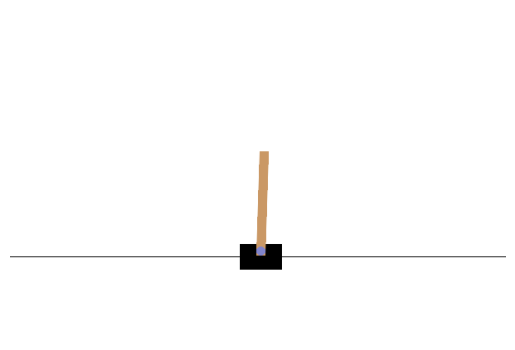

In [ ]:
ENV_NAME = "CartPole-v1"
env = gym.make(ENV_NAME, render_mode="rgb_array")
observation, info = env.reset(seed=42)

# Get a single frame
frame = env.render()

# Display the frame
plt.imshow(frame)
plt.axis('off')  # Hide axes
plt.show()

env.close()

### 1.2.1 Model

The actor-critic model is pretty straightforward.

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, state_size, action_space):
        super(Model, self).__init__()
        # Shared feature extractor
        self.features = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )

        # Actor (policy) head
        self.actor = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_space),
            nn.Softmax(dim=-1)
        )

        # Critic (value) head
        self.critic = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # common net (body)
        x = self.features(x)
        x = x.view(x.size(0), -1)

        # critic
        value = self.critic(x)
        # actor
        actions = self.actor(x)
        return value, actions

    def get_critic(self, x):
        # if we only need the critic prediction
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.critic(x)

    def evaluate_action(self, state, action):
        # returns:
        # 1. Q-value (predicted by critic),
        # 2. log_prob of action distribution
        # 3. entropy of action distribution
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)

        log_probs = dist.log_prob(action).view(-1, 1)
        entropy = dist.entropy().mean()

        return value, log_probs, entropy

    def act(self, state):
        # choose a random action in the state
        value, actor_features = self.forward(state)
        dist = torch.distributions.Categorical(actor_features)

        chosen_action = dist.sample()
        return chosen_action.item()

### 1.2.2 Memory

A small class for storing and retrieving the batches created by the workers in their environments. This is simple data management.

In [ ]:
class Memory(object):
    def __init__(self):
        self.states, self.actions, self.true_values = [], [], []

    def push(self, state, action, true_value):
        self.states.append(state)
        self.actions.append(action)
        self.true_values.append(true_value)

    def pop_all(self):
        states = torch.stack(self.states)
        actions = LongTensor(self.actions)
        true_values = FloatTensor(self.true_values).unsqueeze(1)

        self.states, self.actions, self.true_values = [], [], []

        return states, actions, true_values

### 1.2.3 Compute $Q(s, a)$

There are 2 ways to calculate  actual value of a state $Q(s,a)$ (the sum of all rewards recieved after that point in time):

1. Wait for the episode completion and sum all the rewards $G_t = \sum_k \gamma^k R_{t+k+1}$.
2. Use A2C's critic value predictions and set $Q(s,a) = r + V(s')$.

We combine these $2$ approaches. We take the sum of the rewards with the value of the final state equal to the critic's prediction $R_{end} = V(s_{end})$. Hence we estimate the state value without watiting for the episode's end.

In [ ]:
def compute_true_values(states, rewards, dones):
    R = []
    rewards = FloatTensor(rewards)
    dones = FloatTensor(dones)
    states = torch.stack(states)

    # Value of the final state (if not terminal) = critic's value
    if dones[-1] == True:
        next_value = rewards[-1]
    else:
        next_value = model.get_critic(states[-1].unsqueeze(0))

    R.append(next_value)

    # If a state is terminal (= episode end), then we don't take future rewards.
    for i in reversed(range(0, len(rewards) - 1)):
        if not dones[i]:
            next_value = rewards[i] + next_value * GAMMA
        else:
            next_value = rewards[i]
        R.append(next_value)

    R.reverse()

    return FloatTensor(R)

### 1.2.4 Agent is learning


1. Play $N$ steps in the environment and save the transitions (in an experience replay for example).

2. For every transition $(s_t, a_t, r_t, s_{t+1})$ calculate the “advantage”  obtained from the finite-horizon estimation of T steps: $$\Delta = -V(s_t) +r_t +\gamma r_{t+1} + \dots + \gamma^{T-t+1}r_{T-1} + \gamma^{T-t} V(s_T).$$

3. Calculate the loss of actor and critic for every transition: $$L_w = - \Delta  \cdot \ln \pi_{\theta} (a_t | s_t), \qquad L_v = \Delta ^2.$$

4. Sum up the actor's losses, the critic's losses and an entropy bonus: $$\mathcal{L}_H = \beta \sum_i \pi_{\theta}(a_i) \log \pi_{\theta}(a_i).$$

5. Do the optimizer step for the actor and for the critic.

6. Repeat until converged.

All losses are averaged over a batch size of $80=\text{Batch_Size} * \text{Num_Workers}$.


In [ ]:
def agent_learns(model, optimizer, memory):
    # Step 1. Take a batch of steps.
    states, actions, true_values = memory.pop_all()

    # Step 2. Calculate advantage
    values, log_probs, entropy = model.evaluate_action(states, actions)

    advantages =  true_values - values

    # Step 3. Calculate actor and critic losses
    critic_loss = advantages.pow(2).mean()

    actor_loss = -(log_probs * advantages.detach()).mean()

    # Step 4. Combine the critic loss, actor loss and
    # entropy (to incentivise exploration) to get the final loss.
    # Multipled by coefficients to fine-tune their impact on the training
    total_loss = (CRITIC_COEF * critic_loss) + actor_loss - (ENTROPY_COEF * entropy)

    # Step 5. Optimizer step
    optimizer.zero_grad()
    total_loss.backward()

    # We clip gradient to
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
    optimizer.step()

    return values.mean().item()

# 1.2.5 Worker

We need multiple copies of the environment to decorrelate the data as described earlier. As such, we have a class to take care of instantiating an environment and getting data from it.

In [ ]:
class Worker(object):
    def __init__(self, env_name):
        self.env = gym.make(env_name)
        self.episode_reward = 0
        self.state = FloatTensor(self.env.reset()[0])


    def get_batch(self, model):
        states, actions, rewards, dones = [], [], [], []
        for _ in range(BATCH_SIZE):

            action = model.act(self.state.unsqueeze(0))

            next_state, reward, done, trunc, _ = self.env.step(action)
            done = done or trunc
            next_state = FloatTensor(next_state)

            self.episode_reward += reward

            states.append(self.state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)

            if done:
                self.state =  FloatTensor(self.env.reset()[0])

                data['episode_rewards'].append(self.episode_reward)
                self.episode_reward = 0
            else:
                self.state = FloatTensor(next_state)

        values = compute_true_values(states, rewards, dones).unsqueeze(1)
        return states, actions, values

### 1.2.6 Plotting the data

We display $2$ metrics:

1. **Total reward** for each episode (main performance metric, but has high variance and noisy).

2. **Average value** for each episode returned by the critic = how well the agent *thinks* it's doing (biased, but more stable).

If the critic is taking a very long time to reach an accurate estimate of its own skill, you can probably increase the learning rate. If the agent massively over or underestimates its skill and the gap continues to grow, you've diverged.

In [ ]:
def plot(data, frame_idx):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    if data['episode_rewards']:
        ax = plt.subplot(121)
        ax = plt.gca()
        average_score = np.mean(data['episode_rewards'][-100:])
        plt.title(f"Frame: {frame_idx} - Average Score: {average_score}")
        plt.grid()
        plt.plot(data['episode_rewards'])
    if data['values']:
        ax = plt.subplot(122)
        average_value = np.mean(data['values'][-1000:])
        plt.title(f"Frame: {frame_idx} - Average Values: {average_value}")
        plt.plot(data['values'])
    plt.show()

### 1.2.7 Training

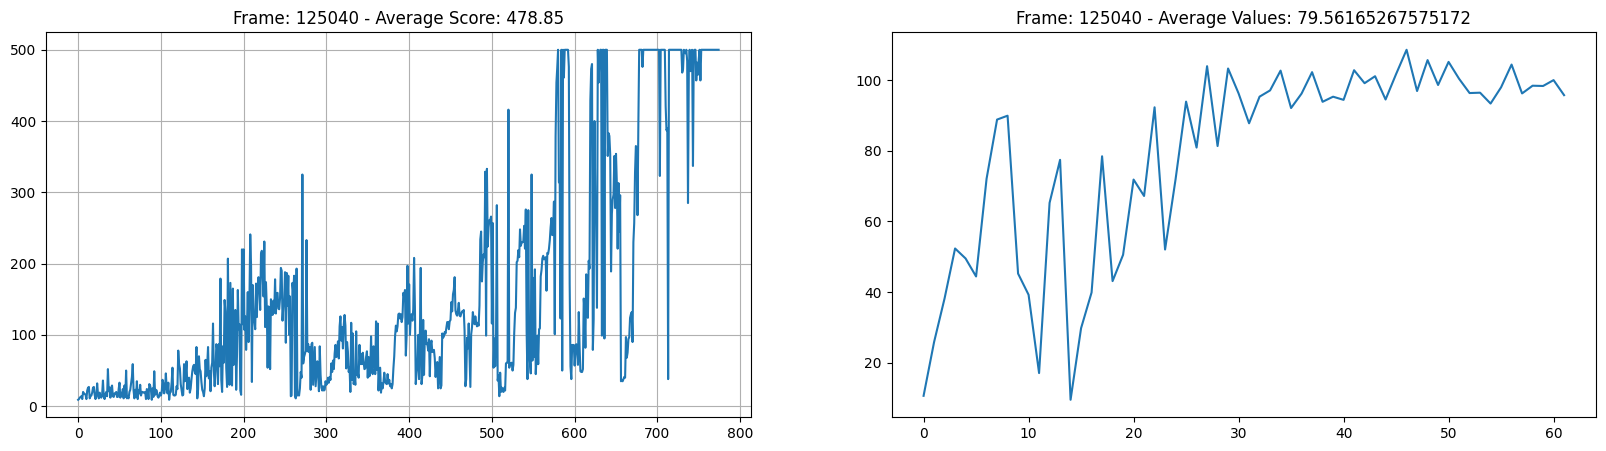

Solved


In [ ]:
ENV_NAME = "CartPole-v1"
env = gym.make(ENV_NAME)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

model = Model(state_size, action_size).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE, eps=1e-5)
memory = Memory()
workers = []
for _ in range(NO_OF_WORKERS):
    workers.append(Worker(ENV_NAME))

# Data to display
data = {
    'episode_rewards': [],
    'values': []
}

frame_idx = 0
while frame_idx < MAX_FRAMES:

    # Play N episodes
    for worker in workers:
        states, actions, true_values = worker.get_batch(model)

        for i, _ in enumerate(states):
            memory.push(
                states[i],
                actions[i],
                true_values[i]
            )
        frame_idx += BATCH_SIZE

    # Update the agent params
    value = agent_learns(model, optimizer, memory)

    # Save data values to display later
    if frame_idx % 500 == 0:
        data['values'].append(value)
        plot(data, frame_idx)

    # CartPole is solved if the score > 475
    average_score = np.mean(data['episode_rewards'][-100:])
    if average_score > 475:
       plot(data, frame_idx)
       print('Solved')
       break

While A2C is a potent tool capable of handling complex environments, it might not be the most efficient choice for simpler tasks.